# Accumulated Local Effects for predicting house prices

In this example we will explain the behaviour of regression models on the Boston housing dataset. We will show how to calculate accumulated local effects (ALE) for determining the feature effects on a model and how these vary on different kinds of models (linear and non-linear models).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE, plot_ale

## Load and prepare the dataset

In [2]:
data = load_boston()
feature_names = data.feature_names
X = data.data
y = data.target
print(feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


Shuffle the data and define the train and test set:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Fit and evaluate models

Fit and evaluate a linear regression model:

In [4]:
lr = LinearRegression()

In [5]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
mean_squared_error(y_test, lr.predict(X_test))

22.098694827098424

Fit and evaluate a random forest model:

In [7]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [8]:
mean_squared_error(y_test, rf.predict(X_test))

10.387403700787404

## Feature Effects: Motivation

Here we develop an intuition for calculating feature effects. We start by illustrating the calculation of feature effects for the linear regression model.

For our regression model, the conditional mean or the prediction function $\mathbb{E}(y\vert x)=f(x)$ is linear:

$$
f(x) = w_0 + w_1x_1 + \dots + w_kx_k.
$$

Because the model is additive and doesn't include feature interactions, we can read off individual feature effects immediately: the effect of any feature $x_i$ is just $w_ix_i$, so the effect is a linear function of $x_i$ and the sign of the coefficient $w_i$ determines whether the effect is positive or negative as $x_i$ changes.

Now suppose we don't know the true effect of the feature $x_i$ which is usually the case when using a more complex model. How might we approach the problem of estimating the effect? Let's focus on one feature - average number of rooms per dwelling (`RM`). The following is a scatterplot of model predictions versus the feature:

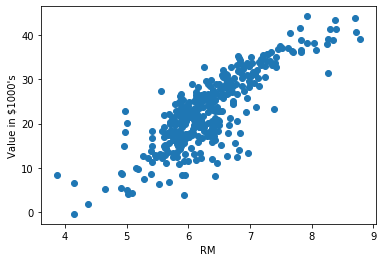

In [9]:
FEATURE = 'RM'
index = np.where(feature_names==FEATURE)[0][0]

fig, ax = plt.subplots()
ax.scatter(X_train[:, index], lr.predict(X_train));

ax.set_xlabel(FEATURE);
ax.set_ylabel('Value in $1000\'s');

 As we can see, there is a strong positive correlation as one might expect. However the feature effects for `RM` cannot be read off immediately because the prediction function includes the effects of all features not just `RM`. What we need is a procedure to block out the effects of all other features to uncover the true effect of `RM` only. This is exactly what the ALE approach does by averaging the differences of predictions across small intervals of the feature.

## Calculate Accumulated Local Effects

Here we initialize the ALE object by passing it the predictor function which in this case is the `clf.predict` method for both models. We also pass in feature names and target name for easier interpretation of the resulting explanations.

In [10]:
lr_ale = ALE(lr.predict, feature_names=feature_names, target_names=['Value in $1000\'s'])
rf_ale = ALE(rf.predict, feature_names=feature_names, target_names=['Value in $1000\'s'])

We now call the `explain` method on the explainer objects which will compute the ALE's and return an `Explanation` object which is ready for inspection and plotting. Since ALE is a global explanation method it takes in a batch of data for which the model feature effects are computed, in this case we pass in the training set.

In [11]:
lr_exp = lr_ale.explain(X_train)
rf_exp = rf_ale.explain(X_train)

In [12]:
lr_exp.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

The resulting `Explanation` objects contain the ALE's for each feature under the `ale_values` attribute - this is a list of numpy arrays, one for each feature. The easiest way to interpret the ALE values is by plotting them against the feature values for which we provide a built-in function `plot_ale`. By calling the function without arguments, we will plot the effects of every feature, so in this case we will get 13 different subplots. To fit them all on the screen we pass in options for the figure size.

## ALE for the linear regression model

The ALE plots show the main effects of each feature on the prediction function.

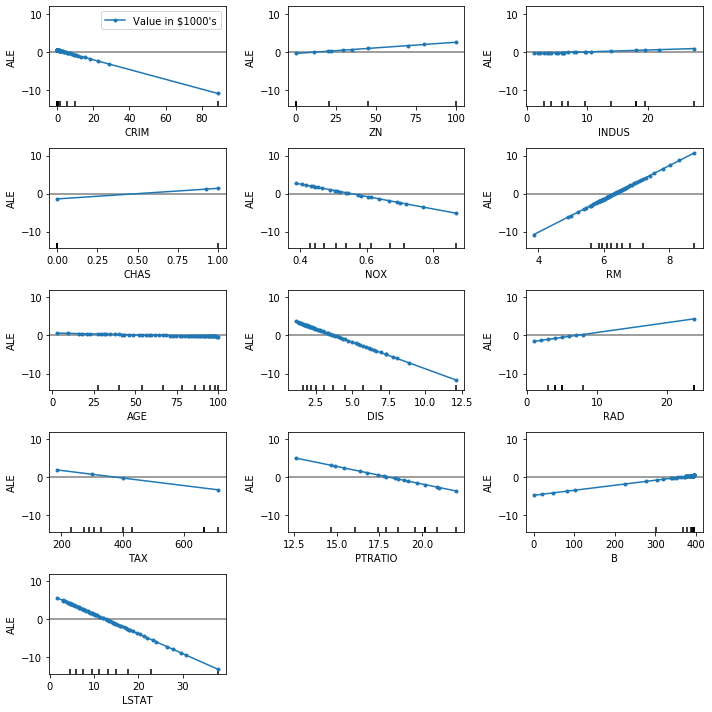

In [13]:
plot_ale(lr_exp, fig_kw={'figwidth':10, 'figheight': 10});

The interpretation of the ALE plot is that given a feature value, the ALE value corresponding to that feature value is difference to the mean effect of that feature. Put differently, the ALE value is the relative feature effect on the prediction at that feature value.

### Effect of the average number of rooms

Let's look at the ALE plot for the feature `RM` (average number of rooms per dwelling) in more detail:

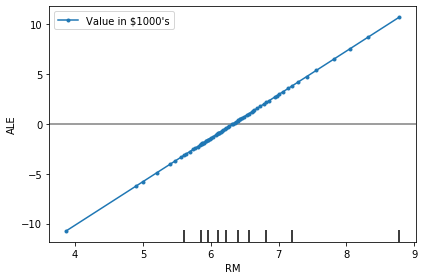

In [14]:
plot_ale(lr_exp, features=['RM']);

The ALE on the y-axes of the plot above is in the units of the prediction variable which, in this case, is the value of the house in \$1000's. The ALE value for the point `RM=8` is ~7.5 which has the interpretation that for neighbourhoods for which the average number of rooms is ~8 the model predicts an up-lift of ~\$7500 **due to feature RM** with respect to the average prediction. On the other hand, for neighbourhoods with an average number of rooms lower than ~6.25, the feature effect on the prediction becomes negative, i.e. a smaller number of rooms brings the predicted value down with respect to the average prediction.

Let's find the neighbourhoods for which the average number of rooms are close to 8:

In [15]:
lower_index = np.where(lr_exp.feature_values[5] < 8)[0][-1]
upper_index = np.where(lr_exp.feature_values[5] > 8)[0][0]
subset = X_train[(X_train[:, 5] > lr_exp.feature_values[5][lower_index])
                 & (X_train[:, 5] < lr_exp.feature_values[5][upper_index])]
print(subset.shape)

(6, 13)


The mean prediction on this subset is:

In [16]:
subset_pred = lr.predict(subset).mean()
subset_pred

38.71963302852489

The zeroth order effects is the mean prediction averaged across the whole dataset:

In [17]:
mean_pred = lr.predict(X_train).mean()
mean_pred

22.907915567282302

The difference between these two values is:

In [18]:
subset_pred - mean_pred

15.811717461242587

This is the total expected uplift in \$1000's for neigbourhoods with the average room number close to 8. The ALE value for `RM=8` tells us that this feature is responsible for roughly \$7.5K or almost half of the uplift while the combination of other features is responsible for the rest.

### Effect of the crime level

An additional feature of the ALE plot is that it shows feature deciles on the x-axis. This helps understand in which regions there is no data so the ALE plot is interpolating. For example, for the `CRIM` feature (per capita crime rate by town), there is very little to no data in the feature interval ~30-85, so the ALE plot in that region is just linearly interpolating:

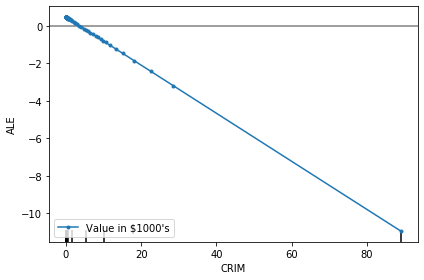

In [19]:
plot_ale(lr_exp, features=['CRIM']);

For linear models this is not an issue as we know the effect is linear across the whole range of the feature, however for non-linear models linear interpolation in feature areas with no data could be unreliable. This is why the use of deciles can help assess in which areas of the feature space the estimated feature effects are more reliable.

### Linearity of ALE

It is no surprise that the ALE plots for the linear regression model are linear themselves—the feature effects are after all linear by definition. In fact, the slopes of the ALE lines are exactly the coefficients of the linear regression:

In [20]:
lr.coef_

array([-1.28322638e-01,  2.95517751e-02,  4.88590934e-02,  2.77350326e+00,
       -1.62388292e+01,  4.36875476e+00, -9.24808158e-03, -1.40086668e+00,
        2.57761243e-01, -9.95694820e-03, -9.23122944e-01,  1.31854199e-02,
       -5.17639519e-01])

In [21]:
slopes = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(lr_exp.ale_values, lr_exp.feature_values)])

In [22]:
slopes

array([-1.28322638e-01,  2.95517751e-02,  4.88590934e-02,  2.77350326e+00,
       -1.62388292e+01,  4.36875476e+00, -9.24808158e-03, -1.40086668e+00,
        2.57761243e-01, -9.95694820e-03, -9.23122944e-01,  1.31854199e-02,
       -5.17639519e-01])

Thus the slopes of the ALE plots for linear regression have exactly the same interpretation as the coefficients of the learnt model—global feature effects. In fact, we can calculate the ALE effect of linear regression analytically (with some assumptions on the conditional feature distributions) to show that the effect of feature $x_i$ is $\text{ALE}(x_i) = w_ix_i-w_i\mathbb{E}(x_i)$ which is the familiar effect $w_ix_i$ relative to the mean effect of the feature.

## ALE for the random forest model

Now let's look at the ALE plots for the non-linear random forest model:

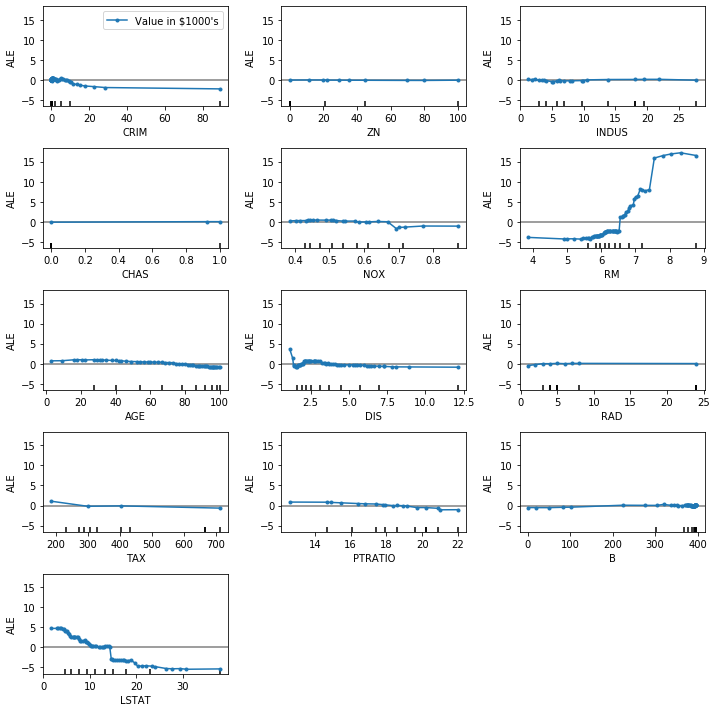

In [23]:
axes = plot_ale(rf_exp, fig_kw={'figwidth':10, 'figheight': 10});

Because the model is no longer linear, the ALE plots are non-linear also and in some cases also non-monotonic. The interpretation of the plots is still the same—the ALE value at a point is the relative feature effect with respect to the mean feature effect, however the non-linear model used shows that the feature effects differ both in shape and magnitude when compared to the linear model.

From these plots, it seems that the feature `RM` has the biggest impact on the prediction. Checking the feature importances of the random forest classifier confirms this:

In [24]:
feature_names[rf.feature_importances_.argmax()]

'RM'

Let's explore the feature `DIS` (weighted distances to five Boston employment centres) and how its effects are different between the two models. To do this, we can pass in matplotlib `axes` objects for the `plot_ale` function to plot on:

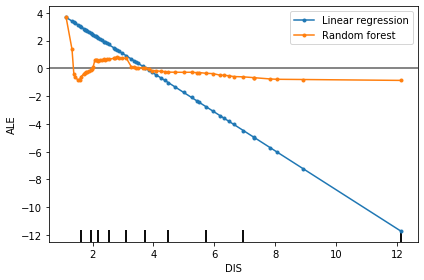

In [25]:
fig, ax = plt.subplots()
plot_ale(lr_exp, features=['DIS'], ax=ax, line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, features=['DIS'], ax=ax, line_kw={'label': 'Random forest'});

From this plot we can gather several interesting insights:

 - Linear regression puts a higher emphasis on the `DIS` feature, as evidenced by the relative magnitudes of the ALE scores across the feature range.
 - Whilst the linear regression feature effects of `DIS` are negatively correlated (the higher the distance to employment centres, the lower the predicted value), the random forest feature effects are not monotonic.
 - In particular, at the start of the range of `DIS` there seems to be switching between positive and negative effects.

To compare multiple models and multiple features we can plot the ALE's on a common axis that is big enough to accommodate all features of interest:

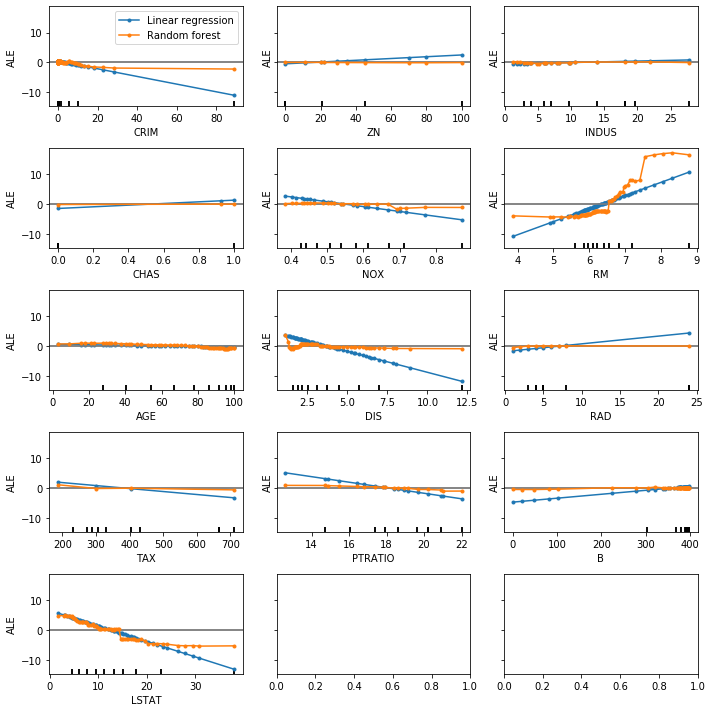

In [26]:
fig, ax = plt.subplots(5, 3, sharey='all');

plot_ale(lr_exp, ax=ax, fig_kw={'figwidth':10, 'figheight': 10},
         line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, ax=ax, line_kw={'label': 'Random forest'});